In [203]:
#Module for Gillespie's Stochastic Simulation Algorithm
import numpy as np
import pandas as pd
import itertools
import random
class GillespieAlgorithm:
    def __init__(self, forward_rxn_list, backward_rxn_list, \
    rxn_rates, nSpecies, \
    rate_modulation_list = None, cell_divison = None, \
    dosage_compensation = None, growth_dependence = None, \
    replication_time = None, division_time = None, partition_prob = None):
        """
        forward_rxn_list: A three-column matrix where for each row, the first
        entry is the id for a molecular species, the second entry is the
        id for a chemical reaction and the third entry is the coefficient for
        the aforementioned molceular species in the output of the
        aforementioned reaction.

        backward_rxn_list: A three-column matrix where for each row, the first
        entry is the id for a molecular species, the second entry is the
        id for a chemical reaction and the third entry is the coefficient for
        the aforementioned molceular species in the input of the
        aforementioned reaction.

        rxn_rates: A vector containing the rates for all the reactions.

        rate_modulation_list: A list of lists of size 'number of reactions'.
        For each element in the list, the first half of the elements gives the
        ids of the molecular species which affect the reaction rate for that
        reaction. The magintude of the second half of entries gives the
        magintude by which the molecular species in the corresponding entries
        in the first half affect the reaction rate and the sign tells whether
        the effect is activating (positive) or repressing (negative).

        mol_count_constraints: A list of lists encoding the constraints on the
        additive relationships between the molecular species. If a subset of
        molecular species are constrained such that the sum of their counts is
        constant, then all of these species will be present as a list in one of
        the entries in this variable; the last element gives the constant value
        of the sum. For species which do not adhere to such contraints, the last
        element is -1.

        nSpecies: Number of different molecular species.

        """

        self.rxn_rates = rxn_rates
        self.nSpecies = nSpecies
        self.rate_modulation_list = rate_modulation_list
        self.forward_rxn_list = forward_rxn_list
        array_ = forward_rxn_list[:, 1]
        self.nReactions = len(dict(enumerate(array_.flatten(), 1)))
        self.backward_rxn_list = backward_rxn_list
        self.cell_divison = cell_divison
        self.dosage_compensation = dosage_compensation
        self.growth_dependence = growth_dependence
        self.time_step = None
        self.propensity = [None] * len(self.rxn_rates)
        self.sampled_rxn_id = None
        self.molecule_count = [None] * self.nSpecies
        self.time_list = [None]

    def propensity_count_prod(self, mol_count, rxn_coeff):
        prod_factor = mol_count
        if rxn_coeff - 1 > 0:
            for _ in range(rxn_coeff - 1):
                prod_factor *= mol_count - _ - 1
        return prod_factor

    def calculate_propensity(self, molecule_count):
        for _ in range(len(self.rxn_rates)):
            self.propensity[_] = self.rxn_rates[_] #propensity list for all the reactions
        if self.cell_divison == None and self.dosage_compensation == None and \
        self.growth_dependence == None:
            for _ in range((self.backward_rxn_list).shape[0]):
                if self.backward_rxn_list[_, 2] != 0:
                    self.propensity[self.backward_rxn_list[_, 1]] *= \
                    self.propensity_count_prod(\
                    molecule_count[self.backward_rxn_list[_, 0]], \
                    self.backward_rxn_list[_, 2])

    def sample_time_step(self):
        a0 = sum(self.propensity)
        r1 = np.random.uniform()
        self.time_step = -np.log(r1)/a0

    def sample_rxn_id(self):
        self.sampled_rxn_id = -1
        a0 = sum(self.propensity)
        r2 = np.random.uniform()
        test = 0
        count = -1
        while test < a0*r2:
            count += 1
            test += self.propensity[count]
        self.sampled_rxn_id = count

    def update_molecule_count(self, molecule_count):
        count_change = [0] * self.nSpecies
        for _ in range((self.forward_rxn_list).shape[0]):
            if self.forward_rxn_list[_, 1] == self.sampled_rxn_id:
                count_change[self.forward_rxn_list[_, 0]] += \
                self.forward_rxn_list[_, 2]

        for _ in range((self.backward_rxn_list).shape[0]):
            if self.backward_rxn_list[_, 1] == self.sampled_rxn_id:
                count_change[self.backward_rxn_list[_, 0]] -= \
                self.backward_rxn_list[_, 2]

        for _ in range(self.nSpecies):
            molecule_count[_] += count_change[_]
        return molecule_count

    def simulate(self, time_, molecule_count):
        time_list = [0]
        molecule_count_cur = [None] * self.nSpecies
        while sum(time_list) < time_:
#             print('Time = ' + str(sum(time_list)))
            for _ in range(self.nSpecies):
                molecule_count_cur[_] = molecule_count[_][-1]
            self.calculate_propensity(molecule_count_cur)
            self.sample_time_step()
            time_list.append(self.time_step)
            self.sample_rxn_id()
            molecule_count_cur = self.update_molecule_count(molecule_count_cur)
            for _ in range(self.nSpecies):
                (molecule_count[_]).append(molecule_count_cur[_])
        self.time_list = time_list
        self.molecule_count = molecule_count
   
    def construct_v(self):
        v = np.zeros((self.nSpecies,len(self.rxn_rates)), dtype = int)
        for mol in range(self.nSpecies):
            for rxn in range(len(self.rxn_rates)):
                for x in self.forward_rxn_list:
                    if x[0] == mol and x[1] == rxn:
                        v[mol][rxn] = x[2]
                        break
    
                for x in self.backward_rxn_list:
                    if x[0] == mol and x[1] == rxn:
                        v[mol][rxn] -= x[2]
                        break
        #print(v)
        return v

    def check_order(self, epsilon):
        epsilon_list = []
        for _ in range(len(self.rxn_rates)):
            epsilon_list.append(epsilon)
        return epsilon_list
        
    def crit_rxns(self, n_c, molecule_count_cur, v):
        is_crit_rxn = np.zeros(len(self.rxn_rates),dtype = bool)
        is_crit_mol = np.zeros(self.nSpecies,dtype = bool)
        for x in self.backward_rxn_list:
            if v[x[0]][x[1]]<0:
                num_poss_rxns = molecule_count_cur[x[0]]/v[x[0]][x[1]]
                if (-1*num_poss_rxns)<n_c:
                    is_crit_rxn[x[1]] = True
                    is_crit_mol[x[1]] = True
        crit_rxns = []
        non_crit_rxns = []
        non_crit_mols = []
        for idx,_ in enumerate(is_crit_rxn):
            if _:
                crit_rxns.append(idx)
            else:
                non_crit_rxns.append(idx)
        
        for idx,_ in enumerate(is_crit_mol):
            if not _:
                non_crit_mols.append(idx)
        return crit_rxns, non_crit_rxns, non_crit_mols
    
    def pick_tau_noncrit(self, molecule_count_cur, v, epsilon_list, non_crit_mols, non_crit_rxns):
        pick_tau_noncrit = [np.inf]
        for mol in range(self.nSpecies):
            top = max(epsilon_list[mol]*molecule_count_cur[mol],1)
            mean = 0
            var = 0
            for rxn in non_crit_rxns:
                mean += v[mol][rxn]*self.propensity[rxn]
                var += (v[mol][rxn]**2)*self.propensity[rxn]
            pick_tau_noncrit.append(min(top/np.abs(mean), (top**2)/var))
        return min(pick_tau_noncrit) 
    
    def pick_tau_crit(self, crit_rxns):
        if len(crit_rxns) == 0:
            return np.inf
        a0c = 0
        for rxn in crit_rxns:
            a0c += self.propensity[rxn]
        r1 = np.random.uniform()
        return -np.log(r1)/a0c
    
    def pick_tau(self,tau_crit, tau_noncrit, crit_rxns):
        if tau_noncrit<tau_crit:
            self.time_step = tau_noncrit
            self.sampled_rxn_id = -1
        else:
            self.time_step = tau_crit
            self.pick_rxn_crit(crit_rxns)
            
    def pick_rxn_crit(self, crit_rxns):
        self.sampled_rxn_id = -1
        if len(crit_rxns) != 0:
            a0c = 0
            for rxn in crit_rxns:
                a0c += self.propensity[rxn]
            r2 = np.random.uniform()
            test = 0
            count = -1
            while test < a0c*r2:
                count += 1
                test += self.propensity[crit_rxns[count]]
            if count == -1:
                self.sampled_rxn_id = -1
            else:
                self.sampled_rxn_id = crit_rxns[count]
            
    
    
    def update_tau_leap(self, tau_noncrit, tau_crit, molecule_count_cur, non_crit_rxns, crit_rxns,v):
        for rxn in non_crit_rxns:
            occurs = np.random.poisson(self.propensity[rxn]*self.time_step)
            for mol in range(self.nSpecies):
                molecule_count_cur[mol] += occurs*v[mol][rxn]
        if self.sampled_rxn_id != -1:
            for mol in range(self.nSpecies):
                molecule_count_cur[mol] += v[mol][rxn]
        return molecule_count_cur
        
    def wrapper(self,tau_noncrit, tau_crit, molecule_count_cur, non_crit_rxns, crit_rxns,v):
        #check if it saves time later
        if tau_noncrit < 1/sum(self.propensity):
            print('run gillespie')
        self.pick_tau(tau_crit, tau_noncrit, crit_rxns)
        if self.time_step == np.inf:
            return molecule_count_cur
        molecule_count_copy = self.update_tau_leap(tau_noncrit, tau_crit, molecule_count_cur, non_crit_rxns, crit_rxns,v)
        if min(molecule_count_copy)>=0:
            return molecule_count_copy
        else:
            self.time_step/=2
            return self.wrapper(tau_noncrit/2, tau_crit, molecule_count_cur, non_crit_rxns, crit_rxns,v)
        
    def tau_leap_simulate(self, time_, molecule_count, n_c, epsilon):
        time_list = [0]
        v = self.construct_v()
        molecule_count_cur = [None] * self.nSpecies
        epsilon_list = self.check_order(epsilon)
        while sum(time_list) < time_:
            for _ in range(self.nSpecies):
                molecule_count_cur[_] = molecule_count[_][-1]
            crit_rxns, non_crit_rxns, non_crit_mols = self.crit_rxns(n_c, molecule_count_cur, v)
            self.calculate_propensity(molecule_count_cur)
            tau_noncrit =  self.pick_tau_noncrit(molecule_count_cur, v, epsilon_list, non_crit_mols, non_crit_rxns)
            tau_crit = self.pick_tau_crit(crit_rxns)
            #print(tau_crit)
            #print(tau_noncrit)
            molecule_count_cur = self.wrapper(tau_noncrit, tau_crit, molecule_count_cur, non_crit_rxns, crit_rxns,v)
            time_list.append(self.time_step)
            for _ in range(self.nSpecies):
                (molecule_count[_]).append(molecule_count_cur[_])
            self.time_list = time_list
            self.molecule_count = molecule_count

In [225]:
forward_rxn_list, backward_rxn_list = np.zeros((4, 3), int), np.zeros((4, 3), int)
forward_rxn_list[0, 0] = 0
forward_rxn_list[0, 1] = 0
forward_rxn_list[0, 2] = 1
forward_rxn_list[1, 0] = 0
forward_rxn_list[1, 1] = 2
forward_rxn_list[1, 2] = 1
forward_rxn_list[2, 0] = 1
forward_rxn_list[2, 1] = 1
forward_rxn_list[2, 2] = 1
forward_rxn_list[3, 0] = 2
forward_rxn_list[3, 1] = 0
forward_rxn_list[3, 2] = 1
backward_rxn_list[0, 0] = 0
backward_rxn_list[0, 1] = 0
backward_rxn_list[0, 2] = 1
backward_rxn_list[1, 0] = 0
backward_rxn_list[1, 1] = 1
backward_rxn_list[1, 2] = 1
backward_rxn_list[2, 0] = 1
backward_rxn_list[2, 1] = 2
backward_rxn_list[2, 2] = 1
backward_rxn_list[3, 0] = 2
backward_rxn_list[3, 1] = 3
backward_rxn_list[3, 2] = 1
rxn_rates = [300, 10, 2, 1]
nSpecies = 3

In [226]:
time_ = 10
molecule_count = [[1], [1],[10]]
two_state = GillespieAlgorithm(forward_rxn_list, backward_rxn_list, rxn_rates, nSpecies)
# two_state.calculate_propensity(molecule_count)
# print(*rxn_rates)
# two_state.sampled_rxn_id = 0

two_state.tau_leap_simulate(time_, molecule_count, 10, .05)
print(*rxn_rates)

300 10 2 1


/Users/lukakarginov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:185: RuntimeWarning: divide by zero encountered in long_scalars


In [222]:
%timeit two_state.tau_leap_simulate(time_, molecule_count, 10, .05)

/Users/lukakarginov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:185: RuntimeWarning: divide by zero encountered in long_scalars
/Users/lukakarginov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:185: RuntimeWarning: divide by zero encountered in double_scalars


KeyboardInterrupt: 

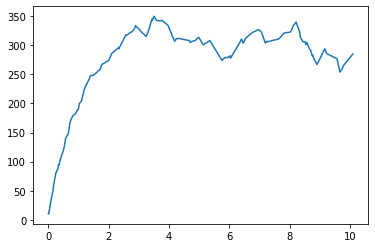

In [227]:
from matplotlib import pyplot as plt
data = {'time': (np.cumsum(two_state.time_list)).tolist(), 'mRNA': two_state.molecule_count[2]}
data = pd.DataFrame(data)
p = plt.plot(data['time'], data['mRNA'])
print(p)

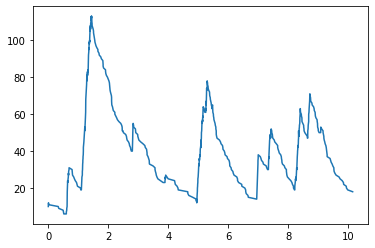

In [231]:
from matplotlib import pyplot as plt
data = {'time': (np.cumsum(two_state.time_list)).tolist(), 'mRNA': two_state.molecule_count[2]}
data = pd.DataFrame(data)
p = plt.plot(data['time'], data['mRNA'])
print(p)

In [229]:
time_ = 10
molecule_count = [[1], [0],[10]]
two_state = GillespieAlgorithm(forward_rxn_list, backward_rxn_list, rxn_rates, nSpecies)
# two_state.calculate_propensity(molecule_count)
# print(*rxn_rates)
# two_state.sampled_rxn_id = 0

two_state.simulate(time_, molecule_count)
print(*rxn_rates)

300 10 2 1


In [217]:
%timeit two_state.simulate(time_, molecule_count)

1.74 s ± 44.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [201]:
forward_rxn_list, backward_rxn_list = np.zeros((2, 3), int), np.zeros((2, 3), int)
forward_rxn_list[0, 0] = 0
forward_rxn_list[0, 1] = 0
forward_rxn_list[0, 2] = 1
forward_rxn_list[1, 0] = 1
forward_rxn_list[1, 1] = 0
forward_rxn_list[1, 2] = 1
backward_rxn_list[0, 0] = 0
backward_rxn_list[0, 1] = 0
backward_rxn_list[0, 2] = 1
backward_rxn_list[1, 0] = 1
backward_rxn_list[1, 1] = 1
backward_rxn_list[1, 2] = 1
rxn_rates = [300, 10]
nSpecies = 2

two_state = GillespieAlgorithm(forward_rxn_list, backward_rxn_list, rxn_rates, nSpecies)